# 来自Transformers的双向编码器表示（BERT）
:label:`sec_bert`

我们已经介绍了几种用于自然语言理解的词嵌入模型。在预训练之后，输出可以被认为是一个矩阵，其中每一行都是一个表示预定义词表中词的向量。事实上，这些词嵌入模型都是与上下文无关的。让我们先来说明这个性质。

## 从上下文无关到上下文敏感

回想一下 :numref:`sec_word2vec_pretraining`和 :numref:`sec_synonyms`中的实验。例如，word2vec和GloVe都将相同的预训练向量分配给同一个词，而不考虑词的上下文（如果有的话）。形式上，任何词元$x$的上下文无关表示是函数$f(x)$，其仅将$x$作为其输入。考虑到自然语言中丰富的多义现象和复杂的语义，上下文无关表示具有明显的局限性。例如，在“a crane is flying”（一只鹤在飞）和“a crane driver came”（一名吊车司机来了）的上下文中，“crane”一词有完全不同的含义；因此，同一个词可以根据上下文被赋予不同的表示。

这推动了“上下文敏感”词表示的发展，其中词的表征取决于它们的上下文。因此，词元$x$的上下文敏感表示是函数$f(x, c(x))$，其取决于$x$及其上下文$c(x)$。流行的上下文敏感表示包括TagLM（language-model-augmented sequence tagger，语言模型增强的序列标记器） :cite:`Peters.Ammar.Bhagavatula.ea.2017`、CoVe（Context Vectors，上下文向量） :cite:`McCann.Bradbury.Xiong.ea.2017`和ELMo（Embeddings from Language Models，来自语言模型的嵌入） :cite:`Peters.Neumann.Iyyer.ea.2018`。

例如，通过将整个序列作为输入，ELMo是为输入序列中的每个单词分配一个表示的函数。具体来说，ELMo将来自预训练的双向长短期记忆网络的所有中间层表示组合为输出表示。然后，ELMo的表示将作为附加特征添加到下游任务的现有监督模型中，例如通过将ELMo的表示和现有模型中词元的原始表示（例如GloVe）连结起来。一方面，在加入ELMo表示后，冻结了预训练的双向LSTM模型中的所有权重。另一方面，现有的监督模型是专门为给定的任务定制的。利用当时不同任务的不同最佳模型，添加ELMo改进了六种自然语言处理任务的技术水平：情感分析、自然语言推断、语义角色标注、共指消解、命名实体识别和问答。

## 从特定于任务到不可知任务

尽管ELMo显著改进了各种自然语言处理任务的解决方案，但每个解决方案仍然依赖于一个特定于任务的架构。然而，为每一个自然语言处理任务设计一个特定的架构实际上并不是一件容易的事。GPT（Generative Pre Training，生成式预训练）模型为上下文的敏感表示设计了通用的任务无关模型 :cite:`Radford.Narasimhan.Salimans.ea.2018`。GPT建立在Transformer解码器的基础上，预训练了一个用于表示文本序列的语言模型。当将GPT应用于下游任务时，语言模型的输出将被送到一个附加的线性输出层，以预测任务的标签。与ELMo冻结预训练模型的参数不同，GPT在下游任务的监督学习过程中对预训练Transformer解码器中的所有参数进行微调。GPT在自然语言推断、问答、句子相似性和分类等12项任务上进行了评估，并在对模型架构进行最小更改的情况下改善了其中9项任务的最新水平。

然而，由于语言模型的自回归特性，GPT只能向前看（从左到右）。在“i went to the bank to deposit cash”（我去银行存现金）和“i went to the bank to sit down”（我去河岸边坐下）的上下文中，由于“bank”对其左边的上下文敏感，GPT将返回“bank”的相同表示，尽管它有不同的含义。

## BERT：把两个最好的结合起来

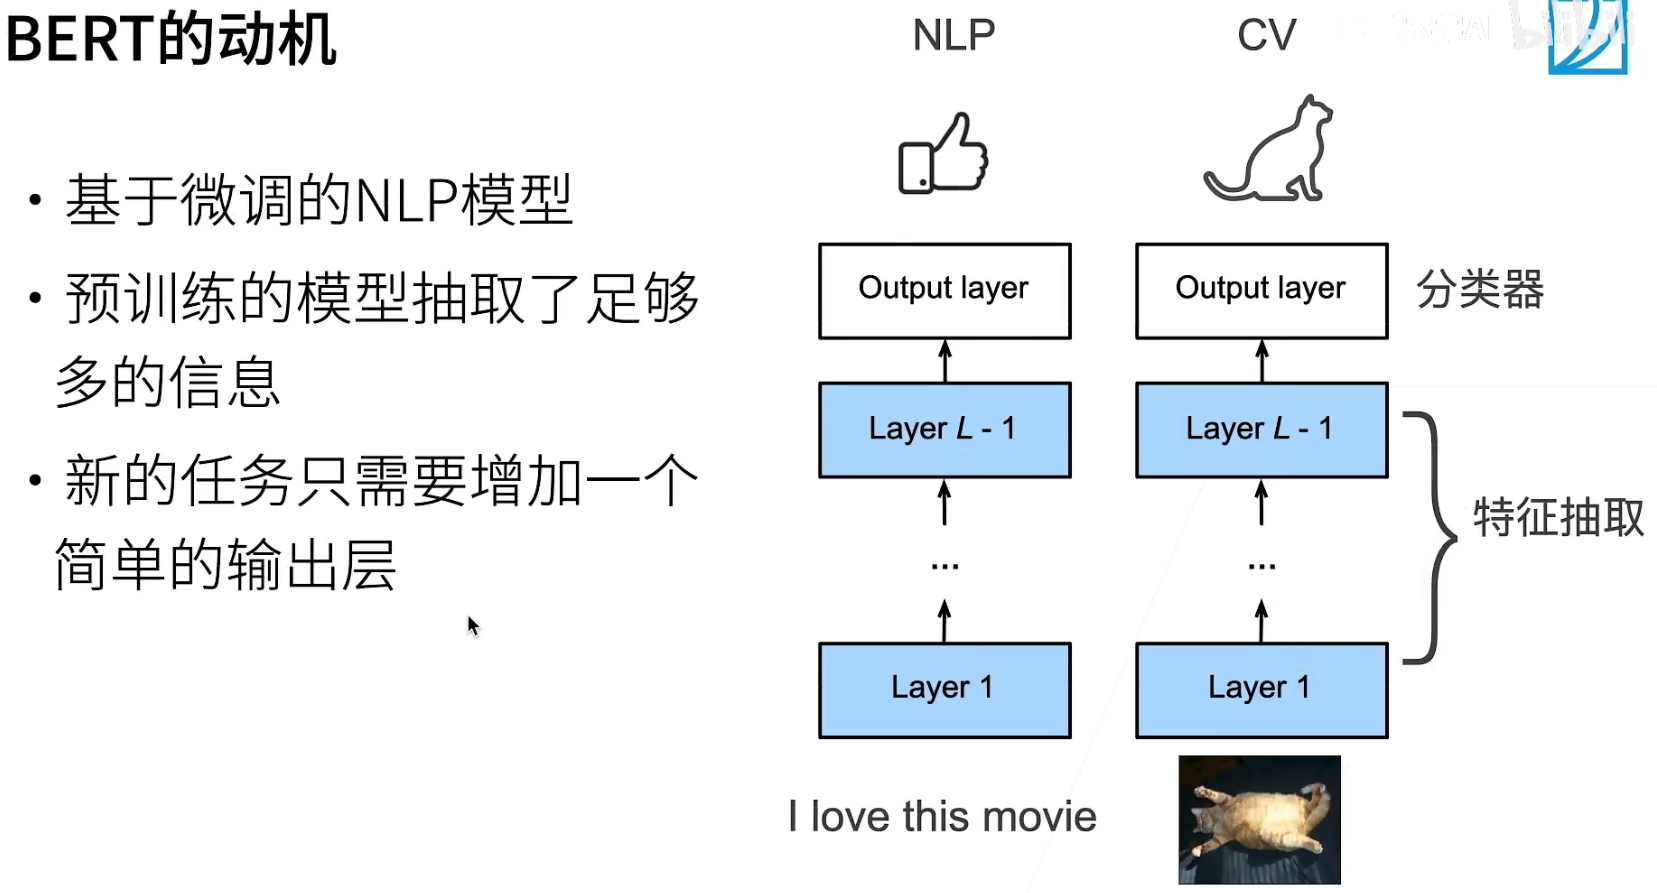
如我们所见，ELMo对上下文进行双向编码，但使用特定于任务的架构；而GPT是任务无关的，但是从左到右编码上下文。BERT（来自Transformers的双向编码器表示）结合了这两个方面的优点。它对上下文进行双向编码，并且对于大多数的自然语言处理任务 :cite:`Devlin.Chang.Lee.ea.2018`只需要最少的架构改变。通过使用预训练的Transformer编码器，BERT能够基于其双向上下文表示任何词元。在下游任务的监督学习过程中，BERT在两个方面与GPT相似。首先，BERT表示将被输入到一个添加的输出层中，根据任务的性质对模型架构进行最小的更改，例如预测每个词元与预测整个序列。其次，对预训练Transformer编码器的所有参数进行微调，而额外的输出层将从头开始训练。 :numref:`fig_elmo-gpt-bert` 描述了ELMo、GPT和BERT之间的差异。

![ELMo、GPT和BERT的比较](../img/elmo-gpt-bert.svg)
:label:`fig_elmo-gpt-bert`    
(GPT:只解码器，预训练，输出层，微调；Bert：只编码器)<br>
BERT进一步改进了11种自然语言处理任务的技术水平，这些任务分为以下几个大类：（1）单一文本分类（如情感分析）、（2）文本对分类（如自然语言推断）、（3）问答、（4）文本标记（如命名实体识别）。从上下文敏感的ELMo到任务不可知的GPT和BERT，它们都是在2018年提出的。概念上简单但经验上强大的自然语言深度表示预训练已经彻底改变了各种自然语言处理任务的解决方案。

在本章的其余部分，我们将深入了解BERT的训练前准备。当在 :numref:`chap_nlp_app`中解释自然语言处理应用时，我们将说明针对下游应用的BERT微调。

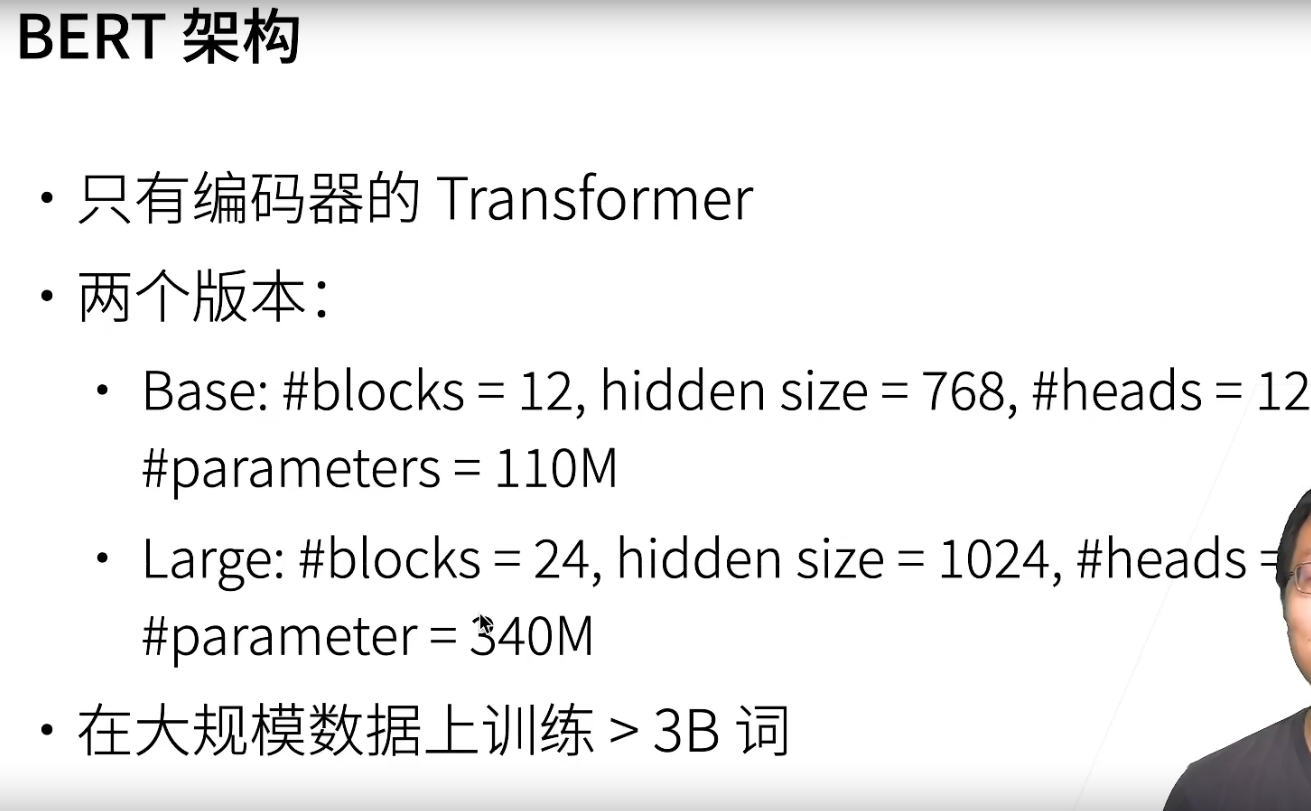

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 输入表示
:label:`subsec_bert_input_rep`

在自然语言处理中，有些任务（如情感分析）以单个文本作为输入，而有些任务（如自然语言推断）以一对文本序列作为输入。BERT输入序列明确地表示单个文本和文本对。当输入为单个文本时，BERT输入序列是特殊类别词元“&lt;cls&gt;”、文本序列的标记、以及特殊分隔词元“&lt;sep&gt;”的连结。当输入为文本对时，BERT输入序列是“&lt;cls&gt;”、第一个文本序列的标记、“&lt;sep&gt;”、第二个文本序列标记、以及“&lt;sep&gt;”的连结。我们将始终如一地将术语“BERT输入序列”与其他类型的“序列”区分开来。例如，一个*BERT输入序列*可以包括一个*文本序列*或两个*文本序列*。

为了区分文本对，根据输入序列学到的片段嵌入$\mathbf{e}_A$和$\mathbf{e}_B$分别被添加到第一序列和第二序列的词元嵌入中。对于单文本输入，仅使用$\mathbf{e}_A$。

下面的`get_tokens_and_segments`将一个句子或两个句子作为输入，然后返回BERT输入序列的标记及其相应的片段索引。


In [2]:
#@save
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """获取输入序列的词元及其片段索引"""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0和1分别标记片段A和B，每个词一个分隔符
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

BERT选择Transformer编码器作为其双向架构。在Transformer编码器中常见是，位置嵌入被加入到输入序列的每个位置。然而，与原始的Transformer编码器不同，BERT使用*可学习的*位置嵌入。总之， 
:numref:`fig_bert-input`表明BERT输入序列的嵌入是词元嵌入、片段嵌入和位置嵌入的和。

![BERT输入序列的嵌入是词元嵌入、片段嵌入和位置嵌入的和](../img/bert-input.svg)
:label:`fig_bert-input`

下面的`BERTEncoder`类类似于 :numref:`sec_transformer`中实现的`TransformerEncoder`类。与`TransformerEncoder`不同，`BERTEncoder`使用片段嵌入和可学习的位置嵌入。


In [3]:
#@save
class BERTEncoder(nn.Module):
    """BERT编码器"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"{i}", d2l.EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        # 在BERT中，位置嵌入是可学习的，因此我们创建一个足够长的位置嵌入参数
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # 在以下代码段中，X的形状保持不变：（批量大小，最大序列长度，num_hiddens）
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

假设词表大小为10000，为了演示`BERTEncoder`的前向推断，让我们创建一个实例并初始化它的参数。


In [4]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,
                      ffn_num_hiddens, num_heads, num_layers, dropout)

我们将`tokens`定义为长度为8的2个输入序列，其中每个词元是词表的索引。使用输入`tokens`的`BERTEncoder`的前向推断返回编码结果，其中每个词元由向量表示，其长度由超参数`num_hiddens`定义。此超参数通常称为Transformer编码器的*隐藏大小*（隐藏单元数）。


In [5]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

## 预训练任务
:label:`subsec_bert_pretraining_tasks`

`BERTEncoder`的前向推断给出了输入文本的每个词元和插入的特殊标记“&lt;cls&gt;”及“&lt;seq&gt;”的BERT表示。接下来，我们将使用这些表示来计算预训练BERT的损失函数。预训练包括以下两个任务：掩蔽语言模型和下一句预测。

### 掩蔽语言模型（Masked Language Modeling）
:label:`subsec_mlm`

如 :numref:`sec_language_model`所示，语言模型使用左侧的上下文预测词元。为了双向编码上下文以表示每个词元，BERT随机掩蔽词元并使用来自双向上下文的词元以自监督的方式预测掩蔽词元。此任务称为*掩蔽语言模型*。

在这个预训练任务中，将随机选择15%的词元作为预测的掩蔽词元。要预测一个掩蔽词元而不使用标签作弊，一个简单的方法是总是用一个特殊的“&lt;mask&gt;”替换输入序列中的词元。然而，人造特殊词元“&lt;mask&gt;”不会出现在微调中。为了避免预训练和微调之间的这种不匹配，如果为预测而屏蔽词元（例如，在“this movie is great”中选择掩蔽和预测“great”），则在输入中将其替换为：

* 80%时间为特殊的“&lt;mask&gt;“词元（例如，“this movie is great”变为“this movie is&lt;mask&gt;”；
* 10%时间为随机词元（例如，“this movie is great”变为“this movie is drink”）；
* 10%时间内为不变的标签词元（例如，“this movie is great”变为“this movie is great”）。

请注意，在15%的时间中，有10%的时间插入了随机词元。这种偶然的噪声鼓励BERT在其双向上下文编码中不那么偏向于掩蔽词元（尤其是当标签词元保持不变时）。

我们实现了下面的`MaskLM`类来预测BERT预训练的掩蔽语言模型任务中的掩蔽标记。预测使用单隐藏层的多层感知机（`self.mlp`）。在前向推断中，它需要两个输入：`BERTEncoder`的编码结果和用于预测的词元位置。输出是这些位置的预测结果。


In [6]:
#@save
class MaskLM(nn.Module):
    """BERT的掩蔽语言模型任务"""
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.Linear(num_hiddens, vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # 假设batch_size=2，num_pred_positions=3
        # 那么batch_idx是np.array（[0,0,0,1,1]）
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

为了演示`MaskLM`的前向推断，我们创建了其实例`mlm`并对其进行了初始化。回想一下，来自`BERTEncoder`的正向推断`encoded_X`表示2个BERT输入序列。我们将`mlm_positions`定义为在`encoded_X`的任一输入序列中预测的3个指示。`mlm`的前向推断返回`encoded_X`的所有掩蔽位置`mlm_positions`处的预测结果`mlm_Y_hat`。对于每个预测，结果的大小等于词表的大小。


In [8]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

通过掩码下的预测词元`mlm_Y`的真实标签`mlm_Y_hat`，我们可以计算在BERT预训练中的遮蔽语言模型任务的交叉熵损失。


In [9]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

### 下一句预测（Next Sentence Prediction）
:label:`subsec_nsp`

尽管掩蔽语言建模能够编码双向上下文来表示单词，但它不能显式地建模文本对之间的逻辑关系。为了帮助理解两个文本序列之间的关系，BERT在预训练中考虑了一个二元分类任务——*下一句预测*。在为预训练生成句子对时，有一半的时间它们确实是标签为“真”的连续句子；在另一半的时间里，第二个句子是从语料库中随机抽取的，标记为“假”。

下面的`NextSentencePred`类使用单隐藏层的多层感知机来预测第二个句子是否是BERT输入序列中第一个句子的下一个句子。由于Transformer编码器中的自注意力，特殊词元“&lt;cls&gt;”的BERT表示已经对输入的两个句子进行了编码。因此，多层感知机分类器的输出层（`self.output`）以`X`作为输入，其中`X`是多层感知机隐藏层的输出，而MLP隐藏层的输入是编码后的“&lt;cls&gt;”词元。


In [10]:
#@save
class NextSentencePred(nn.Module):
    """BERT的下一句预测任务"""
    def __init__(self, num_inputs, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 2)

    def forward(self, X):
        # X的形状：(batchsize,num_hiddens)
        return self.output(X)

我们可以看到，`NextSentencePred`实例的前向推断返回每个BERT输入序列的二分类预测。


In [11]:
encoded_X = torch.flatten(encoded_X, start_dim=1)
# NSP的输入形状:(batchsize，num_hiddens)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

还可以计算两个二元分类的交叉熵损失。


In [12]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

值得注意的是，上述两个预训练任务中的所有标签都可以从预训练语料库中获得，而无需人工标注。原始的BERT已经在图书语料库 :cite:`Zhu.Kiros.Zemel.ea.2015`和英文维基百科的连接上进行了预训练。这两个文本语料库非常庞大：它们分别有8亿个单词和25亿个单词。

## 整合代码

在预训练BERT时，最终的损失函数是掩蔽语言模型损失函数和下一句预测损失函数的线性组合。现在我们可以通过实例化三个类`BERTEncoder`、`MaskLM`和`NextSentencePred`来定义`BERTModel`类。前向推断返回编码后的BERT表示`encoded_X`、掩蔽语言模型预测`mlm_Y_hat`和下一句预测`nsp_Y_hat`。


In [13]:
#@save
class BERTModel(nn.Module):
    """BERT模型"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 hid_in_features=768, mlm_in_features=768,
                 nsp_in_features=768):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape,
                    ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
                    dropout, max_len=max_len, key_size=key_size,
                    query_size=query_size, value_size=value_size)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        self.nsp = NextSentencePred(nsp_in_features)

    def forward(self, tokens, segments, valid_lens=None,
                pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # 用于下一句预测的多层感知机分类器的隐藏层，0是“<cls>”标记的索引
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

## 小结

* word2vec和GloVe等词嵌入模型与上下文无关。它们将相同的预训练向量赋给同一个词，而不考虑词的上下文（如果有的话）。它们很难处理好自然语言中的一词多义或复杂语义。
* 对于上下文敏感的词表示，如ELMo和GPT，词的表示依赖于它们的上下文。
* ELMo对上下文进行双向编码，但使用特定于任务的架构（然而，为每个自然语言处理任务设计一个特定的体系架构实际上并不容易）；而GPT是任务无关的，但是从左到右编码上下文。
* BERT结合了这两个方面的优点：它对上下文进行双向编码，并且需要对大量自然语言处理任务进行最小的架构更改。
* BERT输入序列的嵌入是词元嵌入、片段嵌入和位置嵌入的和。
* 预训练包括两个任务：掩蔽语言模型和下一句预测。前者能够编码双向上下文来表示单词，而后者则显式地建模文本对之间的逻辑关系。

## 练习

1. 为什么BERT成功了？
1. 在所有其他条件相同的情况下，掩蔽语言模型比从左到右的语言模型需要更多或更少的预训练步骤来收敛吗？为什么？
1. 在BERT的原始实现中，`BERTEncoder`中的位置前馈网络（通过`d2l.EncoderBlock`）和`MaskLM`中的全连接层都使用高斯误差线性单元（Gaussian error linear unit，GELU） :cite:`Hendrycks.Gimpel.2016`作为激活函数。研究GELU与ReLU之间的差异。
